In [3]:
import cv2
import os
import glob
import numpy as np
import random
import torch
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:

def get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q):
    move_to_center = np.array([
        [1, 0, center[0]],
        [0, 1, center[1]],
        [0, 0, 1],
    ])

    rotate = np.array([
        [np.cos(q), -np.sin(q), 0],
        [np.sin(q), np.cos(q), 0],
        [0, 0, 1]
    ])

    translate = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1],
    ])

    scale = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

    shear = np.array([
        [1, shy, 0],
        [shx, 1, 0],
        [0, 0, 1]
    ])

    move_back = np.array([
        [1, 0, -center[0]],
        [0, 1, -center[1]],
        [0, 0, 1],
    ])

    matrix = move_to_center @ rotate @ translate @ scale @ shear @ move_back
    matrix_inv = np.linalg.inv(matrix)

    return matrix_inv


def get_random_transformation(image):
    rows, cols, ch = image.shape
    center = (image.shape[1] // 2, image.shape[0] // 2)
    tx = np.random.uniform(-50, 50, 1)[0]
    ty = np.random.uniform(-50, 50, 1)[0]
    sx = np.random.uniform(0.95, 1.05, 1)[0]
    sy = np.random.uniform(0.95, 1.05, 1)[0]
    shx = np.random.uniform(-0.1, 0.1, 1)[0]
    shy = np.random.uniform(-0.1, 0.1, 1)[0]
    q = np.radians(np.random.uniform(-10, 10, 1)[0])

    matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)

    matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
    trans_image = cv2.warpAffine(image, matrix_opencv, (cols, rows))

    h = 500
    w = int(h * 1.5)
    image_crop = image[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]
    trans_image_crop = trans_image[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]

    return trans_image, trans_image_crop, image_crop, [tx, ty, sx, sy, shx, shy, q]


In [12]:
dataset_path = "/Users/ondra/dev/personal/siamese-registration/data/frame_sequences"

In [13]:
class RandomTransformationDataset(Dataset):
    def __init__(self, transforms=None, path=dataset_path):
        self.path = path

        self.transforms = transforms

        self.folder_paths = glob.glob(os.path.join(self.path, '*'))
        self.id_list = []
        self.image_list = []

        for folder in self.folder_paths:
            images = glob.glob(folder + '/*jpg')
            self.id_list.append(os.path.basename(folder))
            self.image_list.extend(images)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = cv2.imread(self.image_list[index])
        trans_image, trans_image_crop, image_crop, params = get_random_transformation(image)
        if self.transforms:
            image_crop = self.transforms(image_crop)
            trans_image_crop = self.transforms(trans_image_crop)
        return image_crop, trans_image_crop, torch.FloatTensor(params)

In [14]:
dataset = RandomTransformationDataset(
        transforms=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]),
        path="/Users/ondra/dev/personal/retinal-registration/data/frame_sequences"
    )

In [15]:
loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=True)

torch.Size([1, 1, 500, 750])
tensor([[ 3.1526e+01, -3.2151e+01,  1.0011e+00,  1.0499e+00,  4.4655e-02,
         -6.2547e-02,  2.1694e-02]])


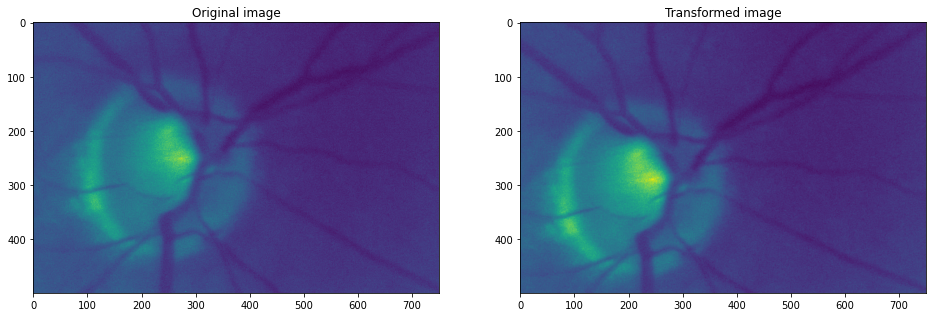

In [16]:
image_crop, trans_image_crop, params = next(iter(loader))

print(image_crop.shape)
print(params)

plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(np.transpose(image_crop[0, :, :, :], (1, 2, 0)))
plt.title('Original image')

plt.subplot(122)
plt.imshow(np.transpose(trans_image_crop[0, :, :, :], (1, 2, 0)))
plt.title('Transformed image')

plt.show()

In [183]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import models

In [201]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = models.resnet50(pretrained=False)
        self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 6)


    def forward(self, input1, input2):
        cnn_out1 = self.cnn1(input1)
        cnn_out2 = self.cnn1(input2)
        
        concat = torch.cat((cnn_out1, cnn_out2), 1)
        
        fc1_out = self.fc1(concat)
        fc1_relu_out = F.relu(fc1_out)
        
        fc2_out = self.fc2(fc1_relu_out)
        fc2_relu_out = F.relu(fc2_out)
        
        output = self.fc3(fc2_relu_out)
        
        return output

In [204]:
dataset = MyDataset(path=dataset_path, transforms=transforms.Compose([transforms.ToTensor(),]))
trainloader = DataLoader(dataset, batch_size=1, shuffle=False)
it = iter(trainloader)

In [205]:
image1, image2, M = next(it)

In [206]:
net = SiameseNetwork()

In [207]:
out = net(image1, image2)

In [208]:
print(out)
print(torch.reshape(out, (1, 2, 3)))
print(M)

tensor([[ 0.0356, -0.0001, -0.1293,  0.0156, -0.0718, -0.0720]],
       grad_fn=<AddmmBackward0>)
tensor([[[ 0.0356, -0.0001, -0.1293],
         [ 0.0156, -0.0718, -0.0720]]], grad_fn=<ReshapeAliasBackward0>)
tensor([[[  0.9848,  -0.1736,  74.4507],
         [  0.1736,   0.9848, -80.9751]]], dtype=torch.float64)


In [277]:
net = SiameseNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

dataset = MyDataset(path=dataset_path, transforms=transforms.Compose([transforms.ToTensor(),]))
trainloader = DataLoader(dataset, batch_size=1, shuffle=False)

running_loss = 0.0
training_loss = []

for epoch in range(0, 10):
    for i, data in enumerate(trainloader):
        img0, img1 , labels = data
        optimizer.zero_grad()
        outputs = net(img0, img1)
        loss = criterion(torch.reshape(outputs, (1, 2, 3)),labels)
        loss_item = loss.item()
        running_loss += loss_item
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, iteration: {i} of {len(trainloader)}, loss: {loss_item}")
    
    training_loss.append(running_loss / len(trainloader))
            

Epoch: 0, iteration: 0 of 252, loss: -0.5945566826500358
Epoch: 0, iteration: 1 of 252, loss: 3.4708432478934115
Epoch: 0, iteration: 2 of 252, loss: 7.231082393986083
Epoch: 0, iteration: 3 of 252, loss: 1.0607746304665318
Epoch: 0, iteration: 4 of 252, loss: 0.30114131220873946


KeyboardInterrupt: 

In [275]:
random.randint(-5, 5)

4